## 1. Configuración Inicial

In [1]:
import sys
from pathlib import Path
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

from ultralytics import YOLO

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Device: cuda
GPU: NVIDIA GeForce RTX 4070


## 2. Cargar Modelos Entrenados

In [2]:
# Paths to trained models
model_v11_path = project_root / 'models' / 'hotspot_detection' / 'yolov11s' / 'weights' / 'best.pt'
model_v8_path = project_root / 'models' / 'hotspot_detection' / 'yolov8s' / 'weights' / 'best.pt'

# Load models
print("Loading models...")
model_v11 = YOLO(str(model_v11_path))
print(f"✓ YOLOv11s loaded from: {model_v11_path}")

model_v8 = YOLO(str(model_v8_path))
print(f"✓ YOLOv8s loaded from: {model_v8_path}")

# Move to device
model_v11.to(device)
model_v8.to(device)

print(f"\nModels ready on {device}")

Loading models...
✓ YOLOv11s loaded from: /home/santiagovasquez/vision_prj/models/hotspot_detection/yolov11s/weights/best.pt
✓ YOLOv8s loaded from: /home/santiagovasquez/vision_prj/models/hotspot_detection/yolov8s/weights/best.pt

Models ready on cuda


## 3. Funciones de Utilidad

In [3]:
def plot_detection(image_path, results_v11, results_v8, figsize=(20, 8)):
    """
    Plot original image with detections from both models side by side.
    """
    # Read image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Original image
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # YOLOv11 detections
    img_v11 = img_rgb.copy()
    for r in results_v11:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            
            # Draw box
            cv2.rectangle(img_v11, (x1, y1), (x2, y2), (255, 0, 0), 3)
            
            # Draw label
            label = f'Hotspot {conf:.2f}'
            cv2.putText(img_v11, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    
    axes[1].imshow(img_v11)
    axes[1].set_title(f'YOLOv11s ({len(results_v11[0].boxes)} detections)', 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # YOLOv8 detections
    img_v8 = img_rgb.copy()
    for r in results_v8:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            
            # Draw box
            cv2.rectangle(img_v8, (x1, y1), (x2, y2), (0, 255, 0), 3)
            
            # Draw label
            label = f'Hotspot {conf:.2f}'
            cv2.putText(img_v8, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    axes[2].imshow(img_v8)
    axes[2].set_title(f'YOLOv8s ({len(results_v8[0].boxes)} detections)', 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


def get_detection_stats(results):
    """
    Extract detection statistics from results.
    """
    stats = []
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            
            stats.append({
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                'confidence': conf,
                'width': x2 - x1,
                'height': y2 - y1,
                'area': (x2 - x1) * (y2 - y1)
            })
    
    return pd.DataFrame(stats)

print("Utility functions loaded ✓")

Utility functions loaded ✓


## 4. Inferencia en Imágenes de Prueba

Found 62 test images
Showing results for first 5 images

Image: Surge_Arresters_FLIR2886.jpg


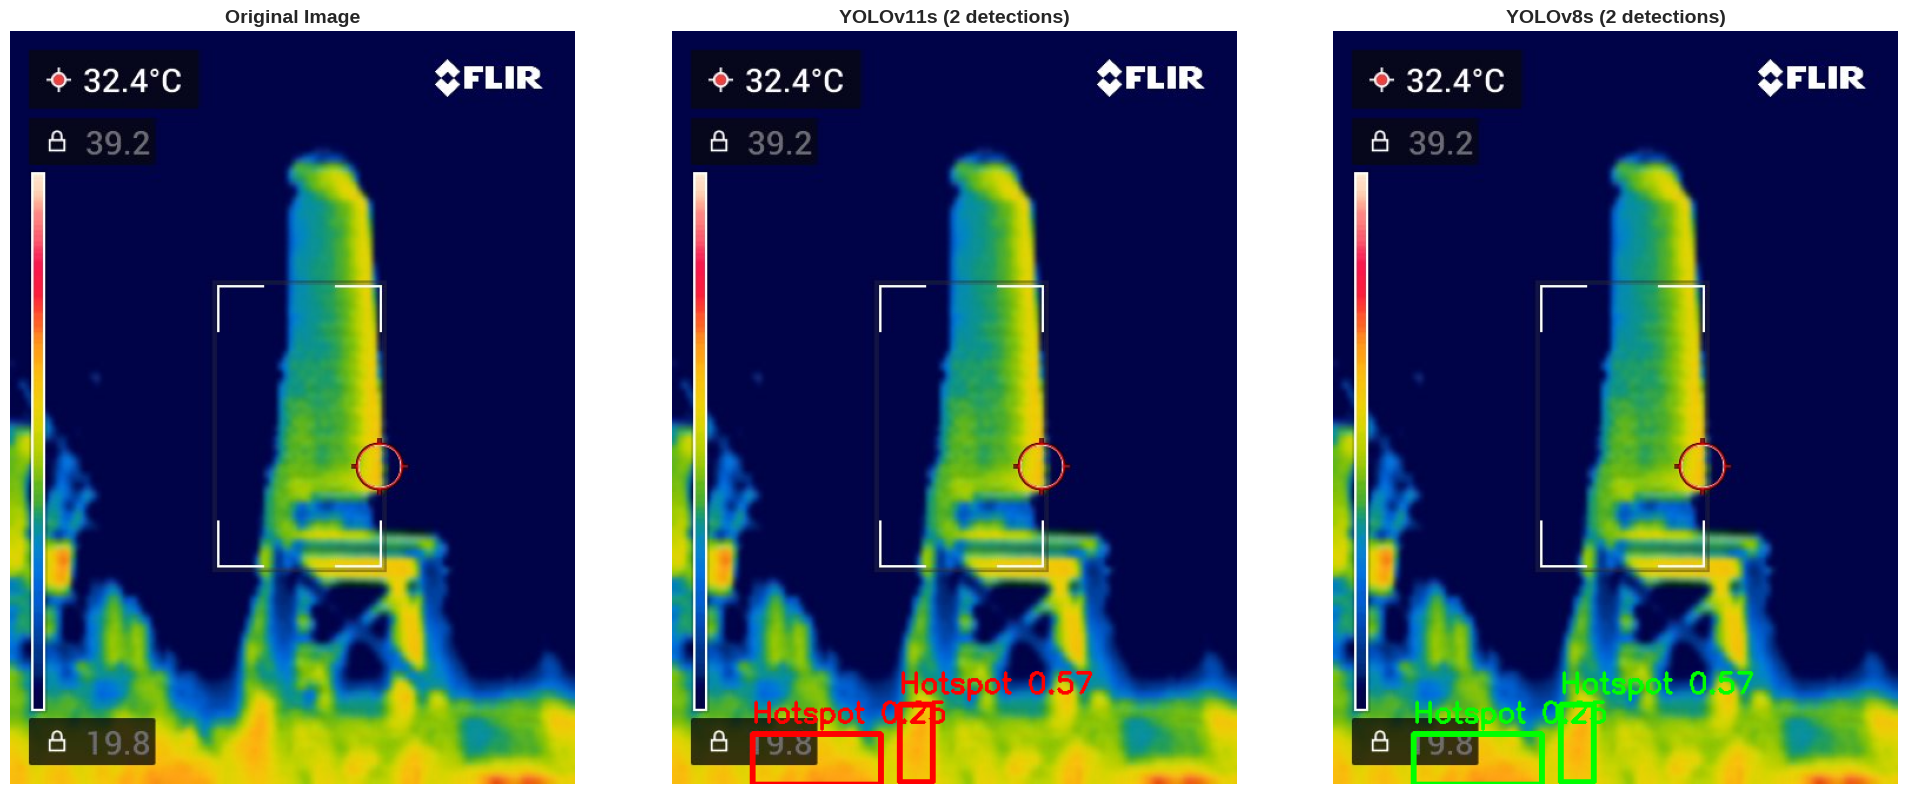


YOLOv11: 2 hotspots detected
  Avg confidence: 0.410
  Max confidence: 0.568

YOLOv8: 2 hotspots detected
  Avg confidence: 0.410
  Max confidence: 0.568

Image: Circuit_Breakers_FLIR4626.jpg


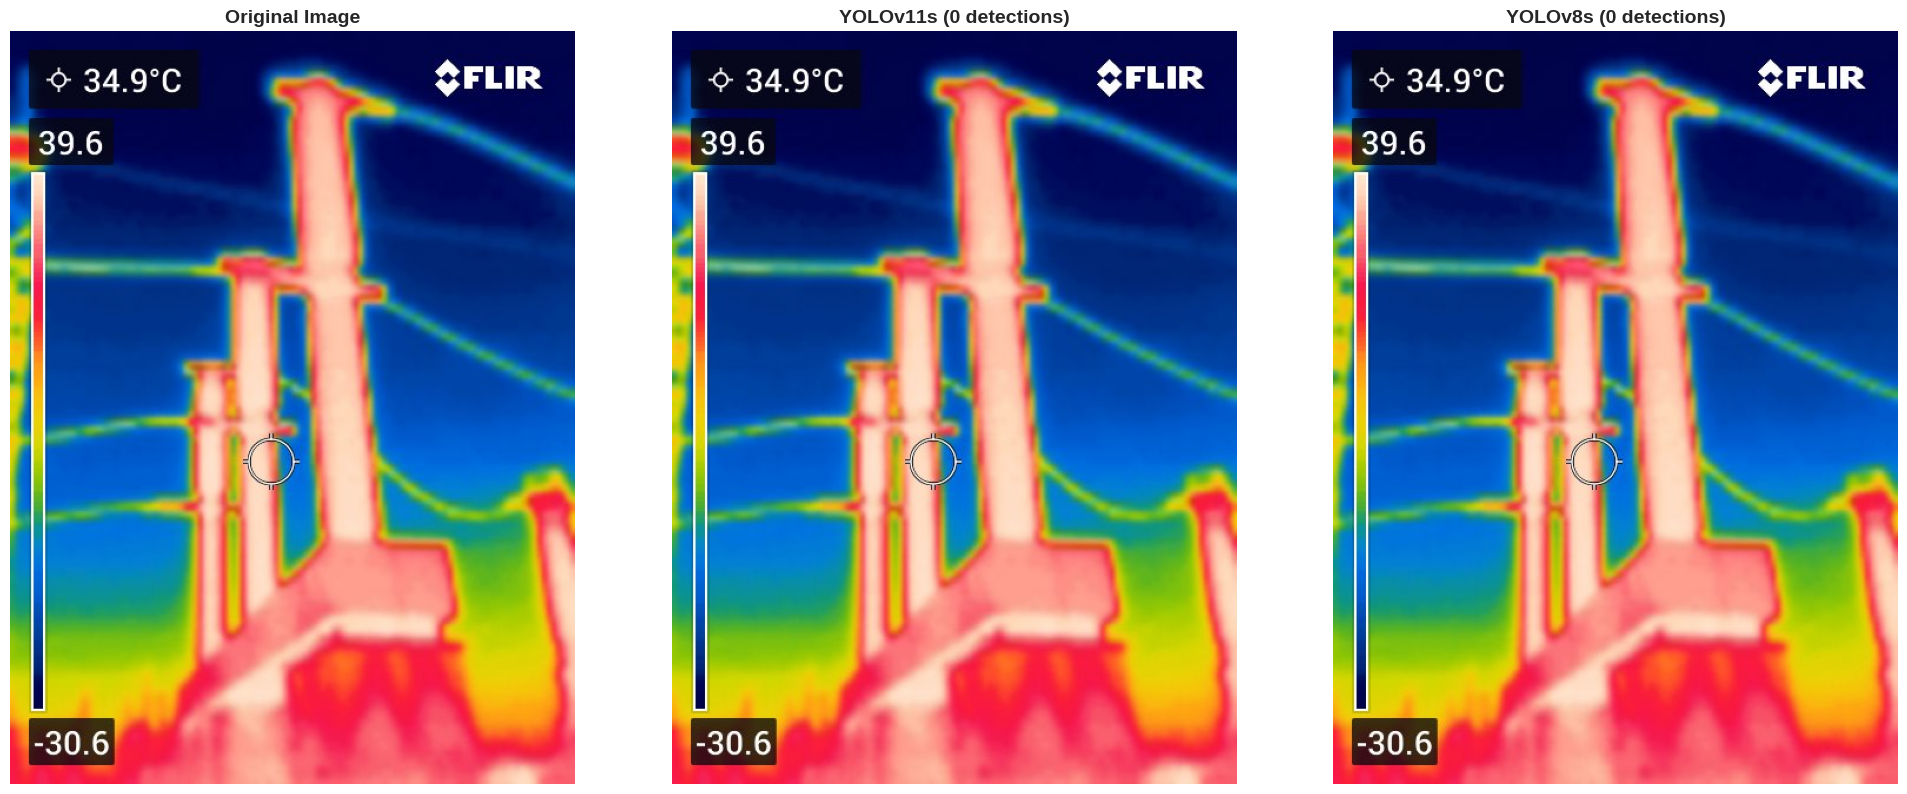


YOLOv11: 0 hotspots detected

YOLOv8: 0 hotspots detected

Image: Disconnectors_FLIR4180.jpg


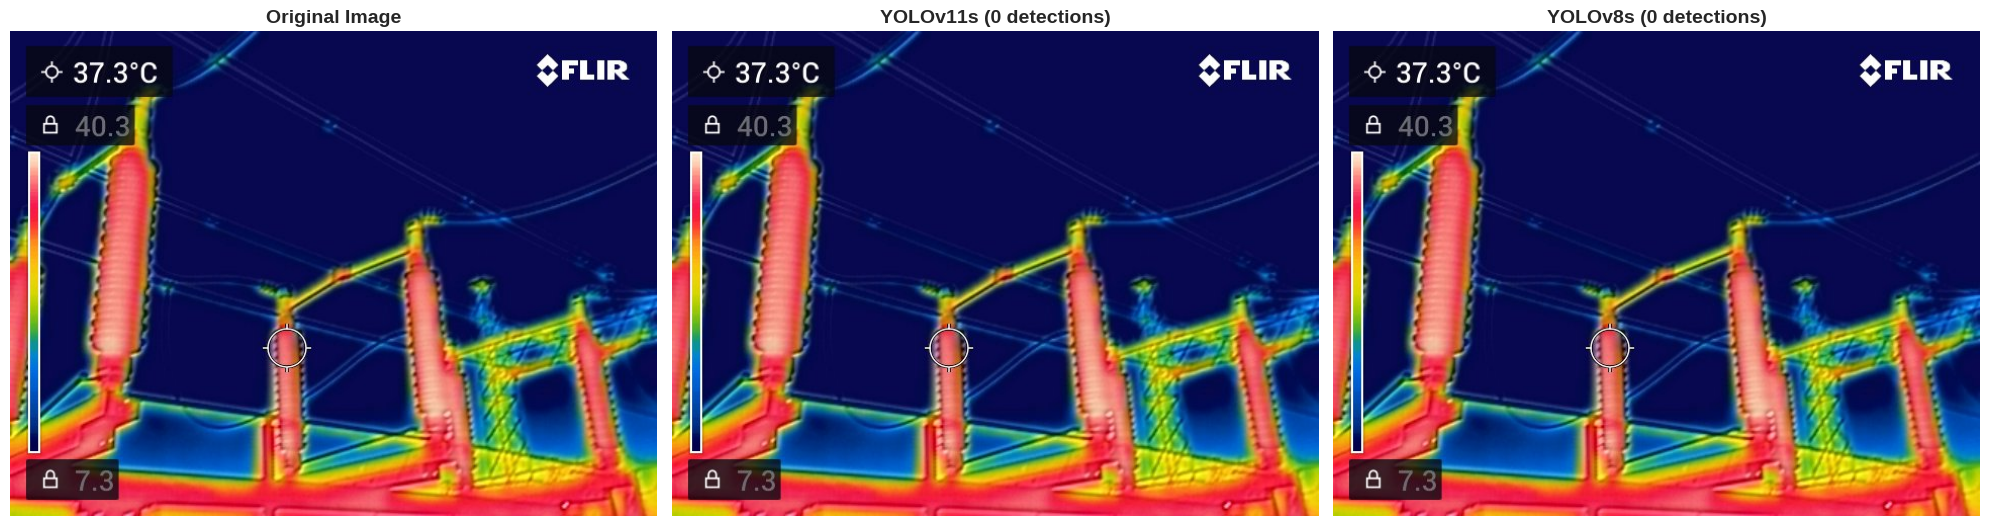


YOLOv11: 0 hotspots detected

YOLOv8: 0 hotspots detected

Image: Surge_Arresters_FLIR2614.jpg


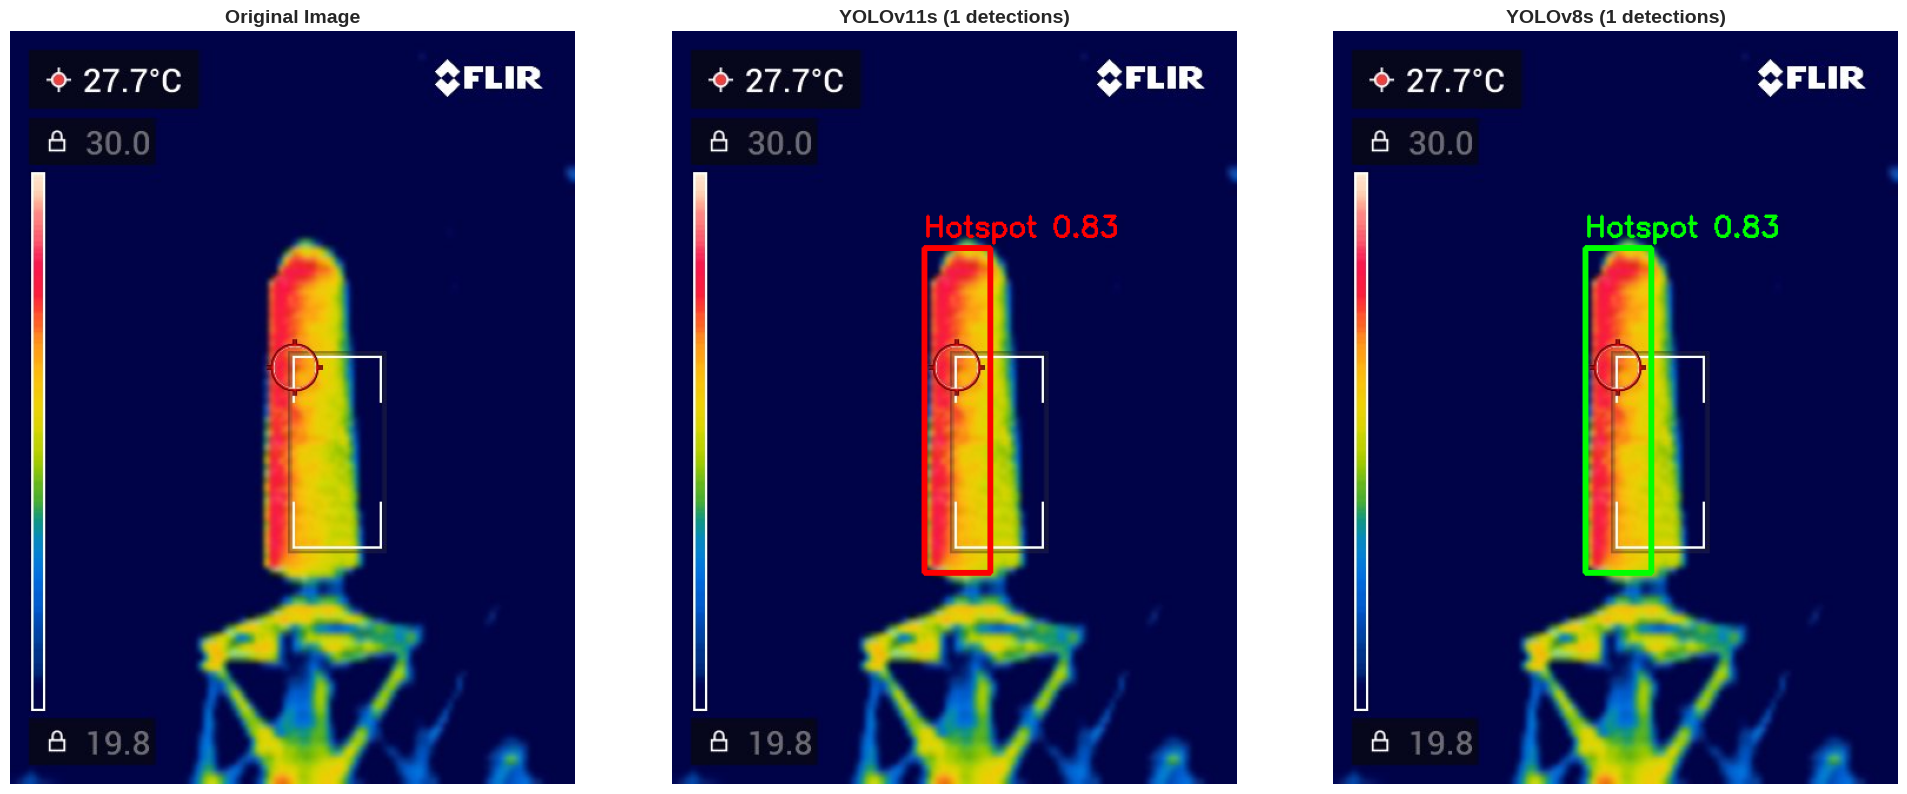


YOLOv11: 1 hotspots detected
  Avg confidence: 0.833
  Max confidence: 0.833

YOLOv8: 1 hotspots detected
  Avg confidence: 0.833
  Max confidence: 0.833

Image: Circuit_Breakers_FLIR4398.jpg


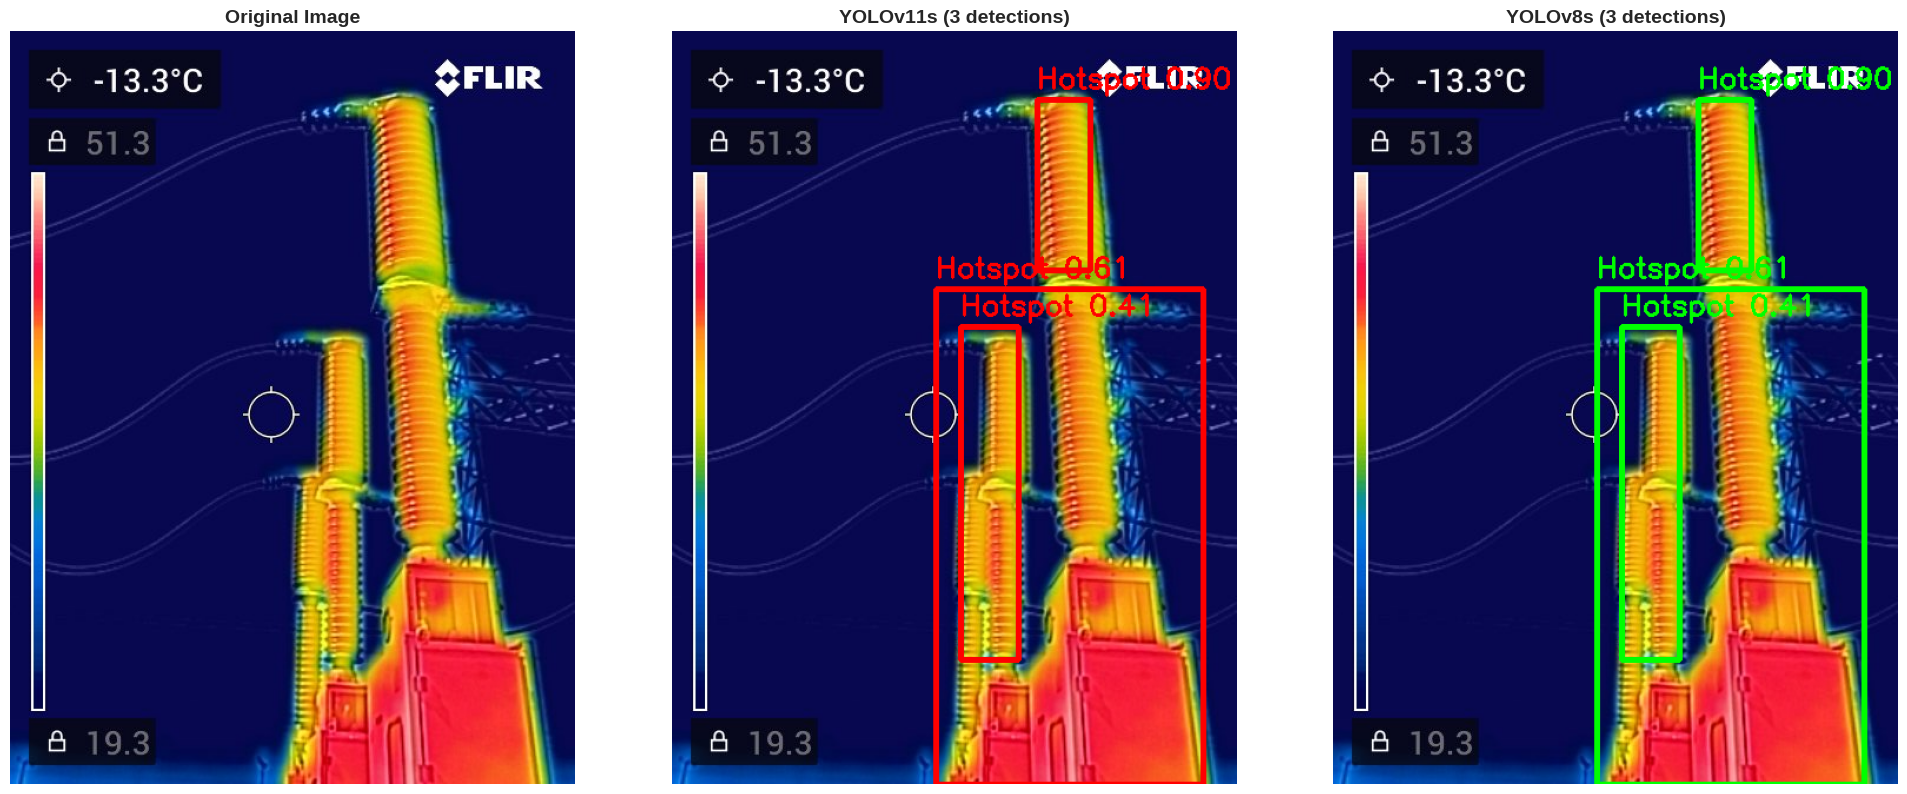


YOLOv11: 3 hotspots detected
  Avg confidence: 0.640
  Max confidence: 0.897

YOLOv8: 3 hotspots detected
  Avg confidence: 0.640
  Max confidence: 0.897



In [4]:
# Path to test images
test_images_dir = project_root / 'data' / 'yolo_detection' / 'test' / 'images'

# Get list of test images
test_images = list(test_images_dir.glob('*.jpg'))[:5]  # First 5 images

print(f"Found {len(list(test_images_dir.glob('*.jpg')))} test images")
print(f"Showing results for first {len(test_images)} images\n")

# Configuration
conf_threshold = 0.25  # Confidence threshold
iou_threshold = 0.45   # NMS IoU threshold

for img_path in test_images:
    print("="*80)
    print(f"Image: {img_path.name}")
    print("="*80)
    
    # Run inference
    results_v11 = model_v11.predict(
        source=str(img_path),
        conf=conf_threshold,
        iou=iou_threshold,
        verbose=False
    )
    
    results_v8 = model_v8.predict(
        source=str(img_path),
        conf=conf_threshold,
        iou=iou_threshold,
        verbose=False
    )
    
    # Plot results
    plot_detection(img_path, results_v11, results_v8)
    
    # Print statistics
    print(f"\nYOLOv11: {len(results_v11[0].boxes)} hotspots detected")
    if len(results_v11[0].boxes) > 0:
        stats_v11 = get_detection_stats(results_v11)
        print(f"  Avg confidence: {stats_v11['confidence'].mean():.3f}")
        print(f"  Max confidence: {stats_v11['confidence'].max():.3f}")
    
    print(f"\nYOLOv8: {len(results_v8[0].boxes)} hotspots detected")
    if len(results_v8[0].boxes) > 0:
        stats_v8 = get_detection_stats(results_v8)
        print(f"  Avg confidence: {stats_v8['confidence'].mean():.3f}")
        print(f"  Max confidence: {stats_v8['confidence'].max():.3f}")
    
    print()

## 5. Inferencia en Imagen Personalizada

In [5]:
# Specify path to your custom image
custom_image_path = test_images_dir / 'Circuit_Breakers_FLIR0002.jpg'  # Change this

if custom_image_path.exists():
    print(f"Processing: {custom_image_path.name}\n")
    
    # Run inference
    results_v11 = model_v11.predict(
        source=str(custom_image_path),
        conf=0.25,
        iou=0.45,
        verbose=False
    )
    
    results_v8 = model_v8.predict(
        source=str(custom_image_path),
        conf=0.25,
        iou=0.45,
        verbose=False
    )
    
    # Plot
    plot_detection(custom_image_path, results_v11, results_v8, figsize=(24, 8))
    
    # Detailed statistics
    print("\n" + "="*80)
    print("Detection Statistics")
    print("="*80)
    
    if len(results_v11[0].boxes) > 0:
        print("\nYOLOv11 Detections:")
        stats_v11 = get_detection_stats(results_v11)
        print(stats_v11.to_string(index=False))
    
    if len(results_v8[0].boxes) > 0:
        print("\nYOLOv8 Detections:")
        stats_v8 = get_detection_stats(results_v8)
        print(stats_v8.to_string(index=False))
else:
    print(f"Image not found: {custom_image_path}")

Image not found: /home/santiagovasquez/vision_prj/data/yolo_detection/test/images/Circuit_Breakers_FLIR0002.jpg


## 6. Evaluación en Conjunto de Test Completo

In [6]:
# Validate on test set
data_yaml = project_root / 'data' / 'yolo_detection' / 'data.yaml'

print("Evaluating YOLOv11s on test set...")
metrics_v11 = model_v11.val(
    data=str(data_yaml),
    split='test',
    batch=16,
    verbose=False
)

print("\nEvaluating YOLOv8s on test set...")
metrics_v8 = model_v8.val(
    data=str(data_yaml),
    split='test',
    batch=16,
    verbose=False
)

# Print comparison
print("\n" + "="*80)
print("Test Set Evaluation Results")
print("="*80)

comparison_data = {
    'Metric': ['mAP@50', 'mAP@50-95', 'Precision', 'Recall'],
    'YOLOv11s': [
        metrics_v11.box.map50,
        metrics_v11.box.map,
        metrics_v11.box.mp,
        metrics_v11.box.mr
    ],
    'YOLOv8s': [
        metrics_v8.box.map50,
        metrics_v8.box.map,
        metrics_v8.box.mp,
        metrics_v8.box.mr
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['YOLOv11s'] - comparison_df['YOLOv8s']

print("\n", comparison_df.to_string(index=False))
print("\n" + "="*80)

Evaluating YOLOv11s on test set...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7490.1±858.5 MB/s, size: 107.0 KB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7490.1±858.5 MB/s, size: 107.0 KB)
val: Scanning /home/santiagovasquez/vision_prj/data/yolo_detection/test/labels... 62 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 62/62 2.9Kit/s 0.0s
val: New cache created: /home/santiagovasquez/vision_prj/data/yolo_detection/test/labels.cache
val: Scanning /home/santiagovasquez/vision_prj/data/yolo_detection/test/labels... 62 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 62/62 2.9Kit/s 0.0s
val: New cache created: /home/santiagovasquez/vision_prj/data/yolo_detection/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 7.1it/s 0.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 7.1it/s 0.6s
                   all         62    

## 7. Exportar Resultados

Results saved to: /home/santiagovasquez/vision_prj/models/hotspot_detection/evaluation/test_set_comparison.csv


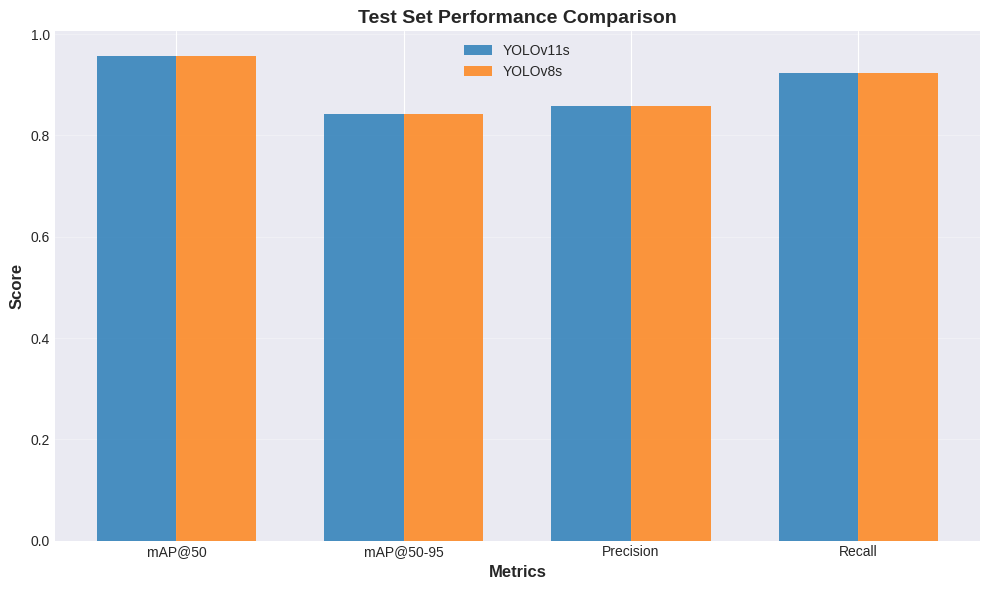


Plot saved to: /home/santiagovasquez/vision_prj/models/hotspot_detection/evaluation/test_comparison.png


In [7]:
# Save comparison results
output_dir = project_root / 'models' / 'hotspot_detection' / 'evaluation'
output_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
comparison_df.to_csv(output_dir / 'test_set_comparison.csv', index=False)
print(f"Results saved to: {output_dir / 'test_set_comparison.csv'}")

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df['Metric']))
width = 0.35

ax.bar(x - width/2, comparison_df['YOLOv11s'], width, label='YOLOv11s', alpha=0.8)
ax.bar(x + width/2, comparison_df['YOLOv8s'], width, label='YOLOv8s', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Test Set Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'test_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {output_dir / 'test_comparison.png'}")

## 8. Limpiar Memoria

In [8]:
if device == 'cuda':
    torch.cuda.empty_cache()
    print("GPU memory cleared")

GPU memory cleared
